# Loading LSTM from training notebook

In [11]:
import torch
import pickle

import sys
sys.path.append('../')  # Go up to src/ directory
from models import LSTM_model

model = LSTM_model()
model.load_state_dict(torch.load('lstm_model.pth'))
scaler_X, scaler_y = pickle.load(open('scalers.pkl', 'rb'))

# Evaluate and plot

In [12]:
import numpy as np
from torch.utils.data import DataLoader
from sklearn.preprocessing import StandardScaler

from dataset import EnergyPriceDataset, load_and_preprocess_energy_data

df = load_and_preprocess_energy_data('../../data/energy_data.csv')

feature_cols = ['Hour', 'day_nr', 'week_nr', 'year', 'wind_forecast_dah_mw', 'consumption_forecast_dah_mw', 'temp_forecast_dah_celcius', 'temp_norm_celcius', 'spot_lag1']
target_col = 'spot'

split_idx = int(len(df) * 0.8)
train_df = df[:split_idx]
test_df = df[split_idx:]

test_features = scaler_X.transform(test_df[feature_cols])
test_targets = scaler_y.transform(test_df[[target_col]])

sequence_length = 24 # 24 = one day, 168 = one week
test_dataset = EnergyPriceDataset(test_features, test_targets, sequence_length)

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

model.eval()
predictions = []
actuals = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        pred = model(X_batch)
        predictions.extend(pred.squeeze().tolist())
        actuals.extend(y_batch.tolist())

predictions = np.array(predictions)
actuals = np.array(actuals)

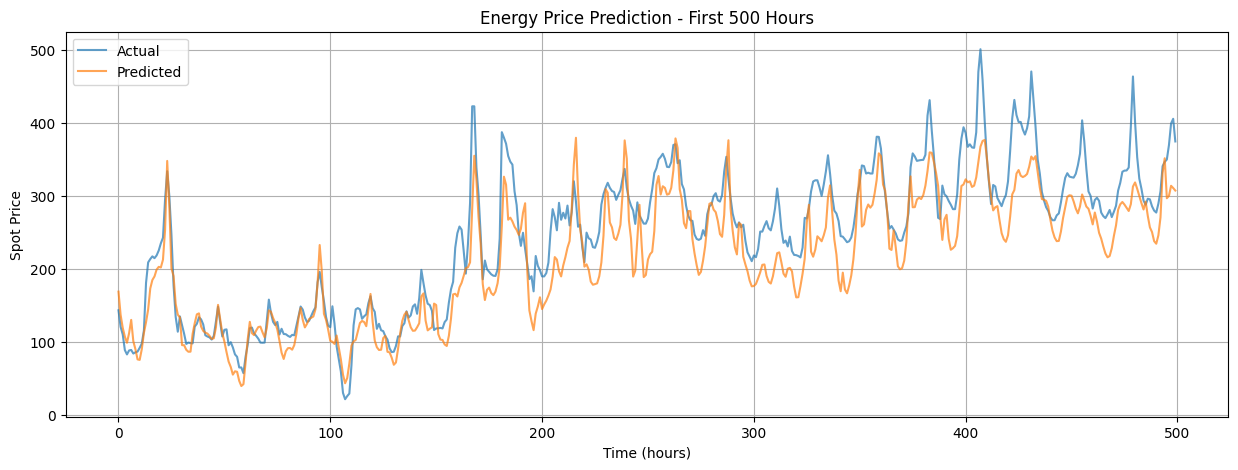

In [13]:
import matplotlib.pyplot as plt

# Inverse transform to get back to original scale
predictions_orig = scaler_y.inverse_transform(predictions.reshape(-1, 1)).flatten()
actuals_orig = scaler_y.inverse_transform(actuals.reshape(-1, 1)).flatten()

# Plot predictions vs actuals
plt.figure(figsize=(15, 5))
plt.plot(actuals_orig[:500], label='Actual', alpha=0.7)
plt.plot(predictions_orig[:500], label='Predicted', alpha=0.7)
plt.xlabel('Time (hours)')
plt.ylabel('Spot Price')
plt.title('Energy Price Prediction - First 500 Hours')
plt.legend()
plt.grid(True)
plt.show()